## Identifying Fradulent Activities

* Build a machine learning model to predict the probability that the first transaction of a new user is fradulent. 

* Explain how different assumptions on the cost of false positive vs.false negative would impact the model. 

* Explain the model from the perspective of users: what kinds of users are more likely to be classified as at risk? 

* Given a model which can predict an activity is fradulent or not in **real time**, what kind of different user experience would you build based on the model output? 

In [1]:
import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
# print(plt.style.available)
plt.style.use('ggplot')
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# plt.rc('figure', figsize=(20, 20))
%matplotlib inline
# https://matplotlib.org/users/style_sheets.html

# Fixing random state for reproducibility
np.random.seed(1)


### Data Preprocess

In [2]:
# load fraud data 
data = pd.read_csv('data/Fraud/Fraud_Data.csv')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
# tell if there are repeated user id 
data['user_id'].is_unique

True

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [5]:
# ip 
ip_map = pd.read_csv('data/Fraud/IpAddress_to_Country.csv')
ip_map.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
ip_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [7]:
data.iloc[1, ]['ip_address']

350311387.865908

In [9]:
ip_map[(ip_map['lower_bound_ip_address'] <= 350311387.865908) &
                          (ip_map['upper_bound_ip_address'] >= 350311387.865908)]['country']

1017    United States
Name: country, dtype: object

In [10]:
# merge the two data sets 

# find the country of each user id 
def merge_data(data, ip_map):
    countries = []
    for i in range(len(data)):
        cur_ip = data.iloc[i, ]['ip_address']
#         print(cur_ip)
        # look up country in ip_map 
        try:
            country_i = ip_map[(ip_map['lower_bound_ip_address'] <= cur_ip) & 
                          (ip_map['upper_bound_ip_address'] >= cur_ip)]['country'].values[0]
#             print(country_i)
        except IndexError:
            country_i = None
        countries.append(country_i)
#         if i % 10000 == 0:
#             print(i)
    data['country'] = countries 
    
    return data 
        
        


In [11]:
all_data = merge_data(data, ip_map)

In [12]:
all_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [148]:
# save merged data 
all_data.to_csv('data/Fraud/all_data.csv', index = False)

In [149]:
all_data = pd.read_csv('data/Fraud/all_data.csv')


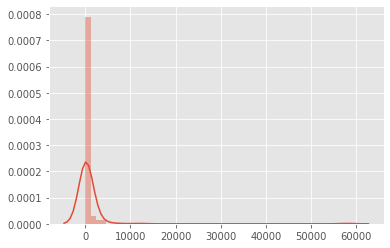

In [151]:
# check users by country 
grouped_country = all_data['country'].value_counts()
sns.distplot(grouped_country.values)

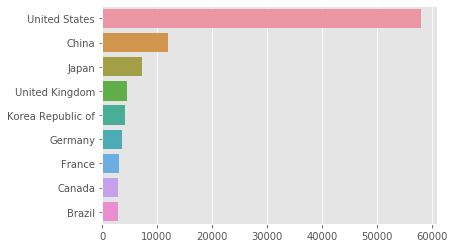

In [152]:
# check users by country 
grouped_country_high = grouped_country[grouped_country > 2000]
sns.barplot(grouped_country_high.values, grouped_country_high.index)

### Feature Engineering

Create ne powerful variables with current data.

* Check the time between sign-up and purchase 

* Check the device id for multiple users / accounts  

* Check ip address 

* Check week/month of a year of events 

In [153]:
all_data['purchase_time'] = pd.to_datetime(all_data['purchase_time'])
all_data['signup_time'] = pd.to_datetime(all_data['signup_time'])


In [154]:
all_data['purchase_sign_diff'] = (all_data['purchase_time'] - all_data['signup_time']).dt.seconds
all_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_sign_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461


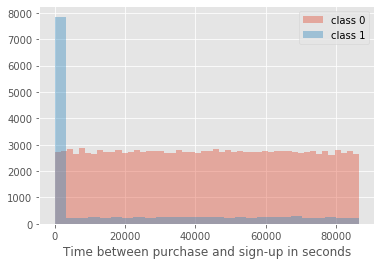

In [155]:
class_0 = all_data[all_data['class'] == 0]
class_1 = all_data[all_data['class'] == 1]
g = sns.distplot(class_0['purchase_sign_diff'], hist = True, label = 'class 0', kde = False)
sns.distplot(class_1['purchase_sign_diff'], hist = True,label = 'class 1', kde = False)
g.set(xlabel='Time between purchase and sign-up in seconds', ylabel='')
g.legend()

#### Fraud events tend to have small time difference between sign-up and purchase. 


In [156]:
# check the number of accounts related to device ids
check_id = all_data.groupby(['class', 'device_id']).size().reset_index()
check_id.rename(columns = {0:'count'}, inplace = True)
check_id.sort_values(by = ['count'], inplace = True, ascending = False)
check_id.head(10)

,class,device_id,count
134900,1,EQYVNEGOFLAWK,19
135981,1,ITUMJCKWEYNDD,19
137202,1,NGQCKIADMZORL,19
136437,1,KIPFSCNUGOLDP,19
140580,1,ZUSVMDEZRBDTX,19
134379,1,CQTUVBYIWWWBC,19
138495,1,SDJQRPKXQFBED,18
135841,1,IGKYVZDBEGALB,18
134792,1,EGLGSEGYPMMAM,18
134177,1,BWSMVSLCJXMCM,18


In [159]:
grouped = all_data.groupby(['class','device_id']).size().reset_index()
grouped.rename(columns = {0:'count'}, inplace = True)
# grouped = grouped['count'].groupby(grouped['class', 'device_id']).sum()
grouped.head()

,class,device_id,count
0,0,AAALBGNHHVMKG,1
1,0,AAAWIHVCQELTP,1
2,0,AAAXJHWCLISKY,1
3,0,AAAXXOZJRZRAO,1
4,0,AABFGRPBQHWFQ,1


In [160]:
# mean users per device by fradulent class
test = grouped['count'].groupby([grouped['class']]).mean().reset_index()
test.rename(columns = {'count':'mean accounts'}, inplace = True)
test  # fraud events have more users per device on average 

,class,mean accounts
0,0,1.024743
1,1,2.025333


In [161]:
# add device_id_count to data 
id_count = all_data['device_id'].value_counts()
all_data['device_id_count'] = all_data['device_id'].map(id_count)
all_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_sign_diff,device_id_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


In [162]:
# check number of users per ip for both classes 
grouped = all_data.groupby(['class','ip_address']).size().reset_index()
grouped.rename(columns = {0:'count'}, inplace = True)
test = grouped['count'].groupby([grouped['class']]).mean().reset_index()
test.rename(columns = {'count':'mean accounts'}, inplace = True)
test  # fraud events have more users per ip on average 

,class,mean accounts
0,0,1.00000
1,1,1.94462


In [163]:
# add shared ip_count to data 
ip_count = all_data['ip_address'].value_counts()
all_data['ip_count'] = all_data['ip_address'].map(ip_count)
all_data.tail()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_sign_diff,device_id_count,ip_count
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,77233,2,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,67270,1,1
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,28816,1,1
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,48519,2,1
151111,138208,2015-06-10 07:02:20,2015-07-21 02:03:53,20,ZINIADFCLHYPG,Direct,IE,M,38,4.103825e+09,0,NaN,68493,1,1


In [165]:
# add week of a year 
all_data['purchase_wk'] = all_data['purchase_time'].dt.week
all_data['signup_wk'] = all_data['signup_time'].dt.week
all_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_sign_diff,device_id_count,ip_count,purchase_wk,signup_wk
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,16,9
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,24,23
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,60085,1,1,19,18
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,37,30


In [170]:
all_data.info() # country has missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 17 columns):
user_id               151112 non-null int64
signup_time           151112 non-null datetime64[ns]
purchase_time         151112 non-null datetime64[ns]
purchase_value        151112 non-null int64
device_id             151112 non-null object
source                151112 non-null object
browser               151112 non-null object
sex                   151112 non-null object
age                   151112 non-null int64
ip_address            151112 non-null float64
class                 151112 non-null int64
country               129146 non-null object
purchase_sign_diff    151112 non-null int64
device_id_count       151112 non-null int64
ip_count              151112 non-null int64
purchase_wk           151112 non-null int64
signup_wk             151112 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(9), object(5)
memory usage: 19.6+ MB


In [171]:
# replace missing country values with NA 
all_data['country'] = all_data['country'].fillna(value = 'NA')

In [173]:
# add dummy variables 
data = pd.get_dummies(all_data, columns = ['sex','source', 'country'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,browser,age,ip_address,class,purchase_sign_diff,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,Chrome,39,7.327584e+08,0,13882,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Chrome,53,3.503114e+08,0,17944,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,Opera,53,2.621474e+09,1,1,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,Safari,41,3.840542e+09,0,60085,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Safari,45,4.155831e+08,0,41461,...,1,0,0,0,0,0,0,0,0,0


In [178]:
# drop unnecesary column 
data = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'browser', 'ip_address'], axis = 1)
data.head()

,purchase_value,age,class,purchase_sign_diff,device_id_count,ip_count,purchase_wk,signup_wk,sex_F,sex_M,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,34,39,0,13882,1,1,16,9,0,1,...,0,0,0,0,0,0,0,0,0,0
1,16,53,0,17944,1,1,24,23,1,0,...,1,0,0,0,0,0,0,0,0,0
2,15,53,1,1,12,12,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0
3,44,41,0,60085,1,1,19,18,0,1,...,0,0,0,0,0,0,0,0,0,0
4,39,45,0,41461,1,1,37,30,0,1,...,1,0,0,0,0,0,0,0,0,0


## Build model

In [200]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


In [185]:
X = data.drop('class', axis = 1)
Y = data['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [197]:
clf = RandomForestClassifier(n_estimators = 300, criterion='entropy', max_depth = 5)
rf_clf = clf.fit(X, Y)

In [194]:
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

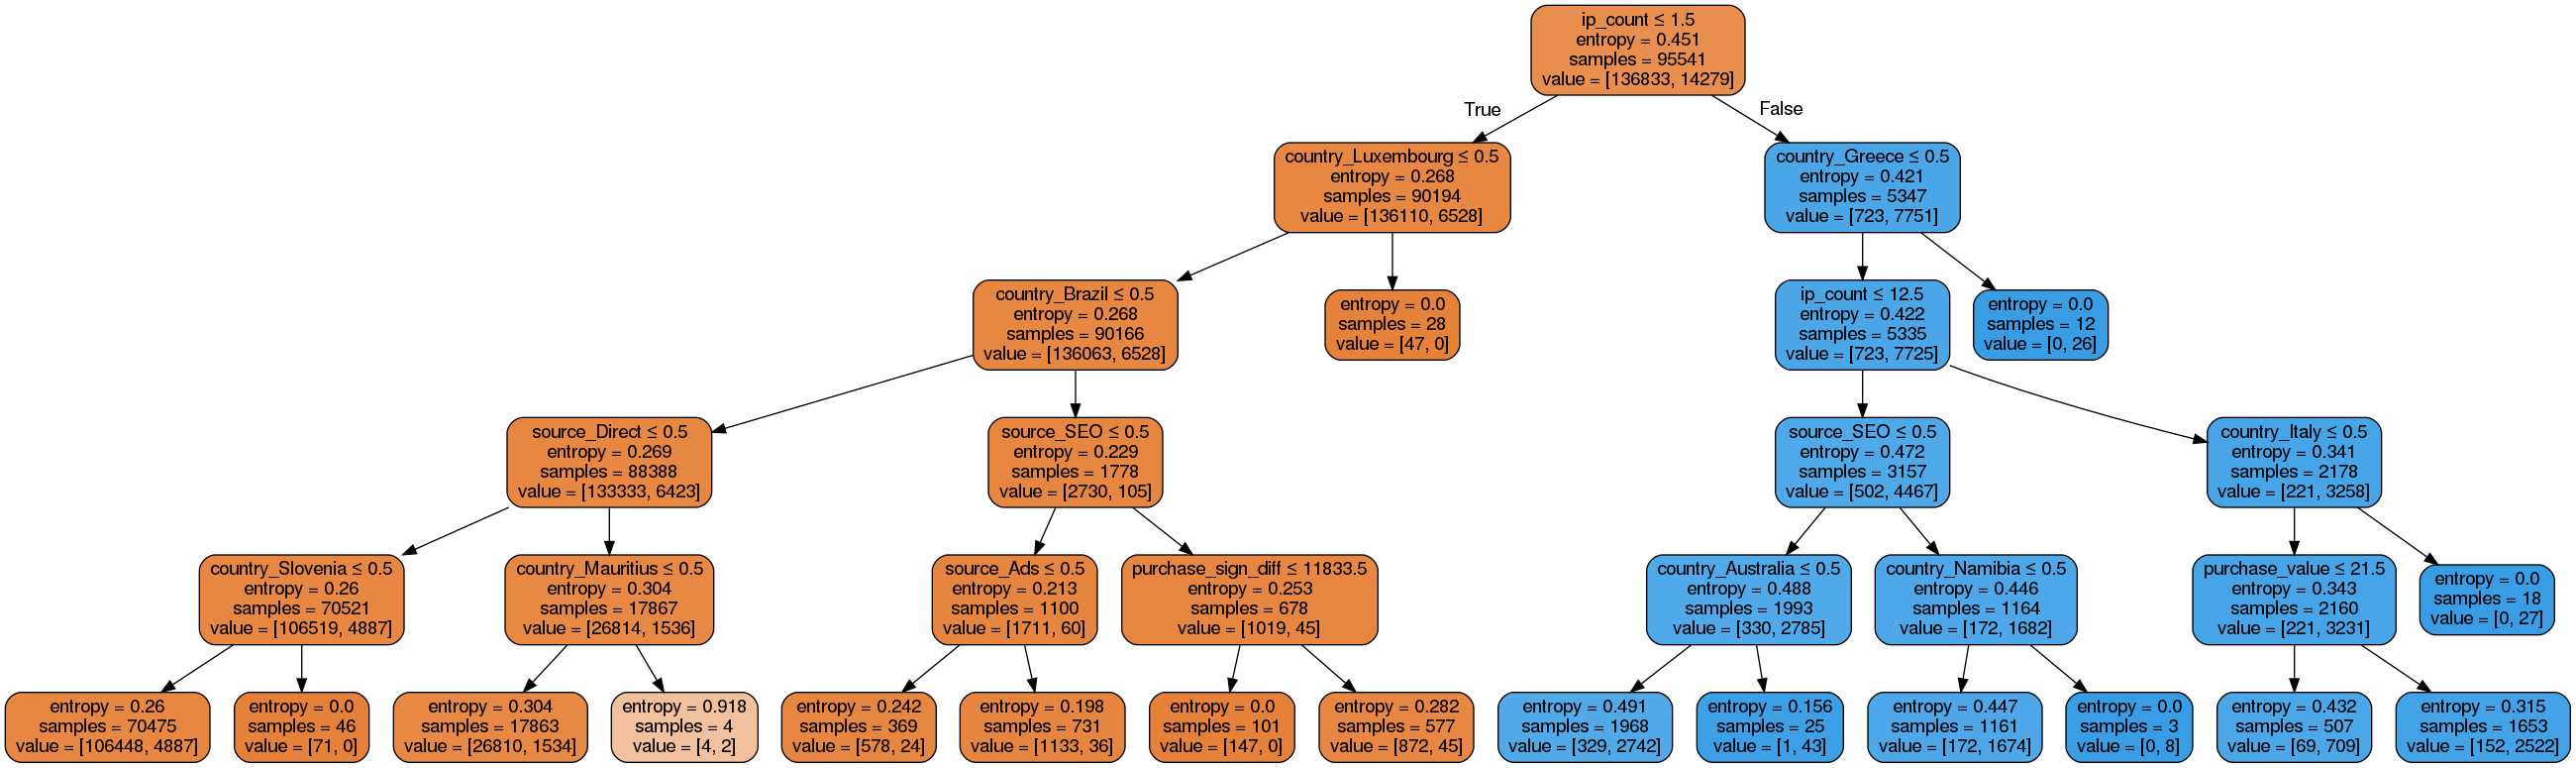

In [199]:
# graph a single tree from a forest 
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
rf_tree = StringIO()
export_graphviz(rf_clf.estimators_[299], out_file = rf_tree,  
                feature_names = X_train.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(rf_tree.getvalue())  
Image(graph.create_png())


In [203]:
# confusion matrix on train data 
y_train_pred = rf_clf.predict(X_train)
confusion_matrix(Y_train, y_train_pred)

array([[95967,     1],
       [ 4549,  5261]])

In [204]:
# confusion matrix on test data 
y_test_pred = rf_clf.predict(X_test)
confusion_matrix(Y_test, y_test_pred)

array([[40988,     5],
       [ 2002,  2339]])

In [212]:
y_scores = rf_clf.predict_proba(X_train)
y_scores[:10]

array([[0.94896433, 0.05103567],
       [0.9475309 , 0.0524691 ],
       [0.94944816, 0.05055184],
       [0.94872935, 0.05127065],
       [0.9495451 , 0.0504549 ],
       [0.94869853, 0.05130147],
       [0.94662308, 0.05337692],
       [0.90145112, 0.09854888],
       [0.94821701, 0.05178299],
       [0.94764166, 0.05235834]])

In [214]:
# roc curve 
fpr, tpr, thresholds = roc_curve(Y_train, y_scores[:, 1])

array([1.81219225, 0.81219225, 0.80256283, ..., 0.04725913, 0.04720361,
       0.04479935])

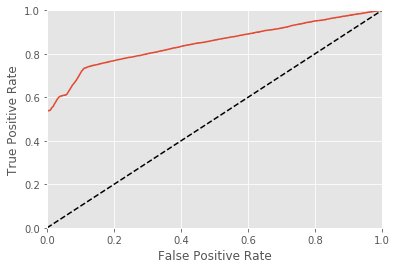

In [215]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

#### If we want to minimize the false positive rate, we may choose a threshold cutoff that gives about 0.5 true positive rate. If we want to maxmize true positive, we need to decrease the threshold. 

## Feature Importance

In [218]:
# feature importance 
feature_importances = pd.DataFrame(rf_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
purchase_sign_diff,0.235509
ip_count,0.218181
device_id_count,0.204256
purchase_wk,0.177643
signup_wk,0.126957


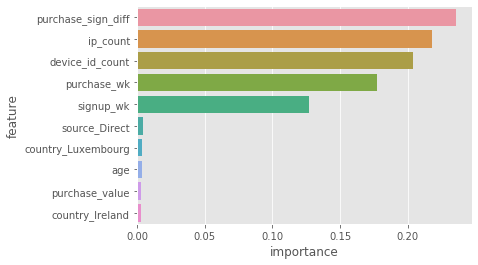

In [225]:
top_ten = feature_importances[:10].reset_index()
top_ten.rename(columns = {'index':'feature'}, inplace = True)
sns.barplot(x = 'importance', y = 'feature', data = top_ten)


#### Users with short interval between purchase time and signup time, shared ip, and shared devices are more likely to be at risk. 

## Use our results from a product perspective 

* If predicted fraud probability < p1 (a threshold), the user has normal experience. 

* If p1 <= predicted fraud probability < p2, the user is at risk, but not much, can create additional verification step for the user. 

* If predicted fraud probability >= p2, the uesr is highly at risk, can put the account on hold and send the info to a person to review it manually. 